<a href="https://colab.research.google.com/github/patsoong/CS506FinalProject/blob/main/notebooks/All_models_and_visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from datasets import load_dataset
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Importing Data and Creating Test/Train Sets

In [21]:
features_df = load_dataset("dlpacoos/CS506_NBA", data_files="team_season_features_v2_clean-2.csv")
features_df = features_df["train"].to_pandas()

#remove features not to be used in training data
num_cols = features_df.select_dtypes(include="number").columns.tolist()
for col in ["champion", "season"]:
    if col in num_cols:
        num_cols.remove(col)

# add season-relative features (rank and z-score within each season)
for col in num_cols:
    features_df[f'{col}_season_rank'] = features_df.groupby('season')[col].rank(pct=True)
    features_df[f'{col}_season_zscore'] = features_df.groupby('season')[col].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
    )

# update feature list
num_cols_extended = features_df.select_dtypes(include="number").columns.tolist()
for col in ["champion", "season"]:
    if col in num_cols_extended:
        num_cols_extended.remove(col)

X = features_df[num_cols_extended].copy()
X = X.replace([np.inf, -np.inf], np.nan)
y = features_df["champion"].astype(int)

#temporal split
train_mask = features_df["season"] <= 2015
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

id_test = features_df.loc[~train_mask, ["season", "team", "champion"]].copy()

##Logistic Regression



In [22]:
# model creation
log_reg = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("scale", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(
        multi_class='ovr',
        class_weight='balanced',
        max_iter=10000,
        C=0.05,
        random_state=42
        ))
])

log_reg.fit(X_train, y_train)
probabilities = log_reg.predict_proba(X_test)[:, 1]

# Metrics
print("LogReg ROC-AUC:", roc_auc_score(y_test, probabilities))
print("LogReg Average Precision (PR-AUC):", average_precision_score(y_test, probabilities))

pred_labels = (probabilities > 0.5).astype(int)
print("LogReg Binary accuracy:", accuracy_score(y_test, pred_labels))

id_test["proba_win"] = probabilities

id_test["ranking_score"] = id_test["proba_win"]
id_test["rank"] = (
    id_test.groupby("season")["ranking_score"]
           .rank(ascending=False, method="first")
)

idx = id_test.groupby("season")["proba_win"].idxmax()

predicted_champs = (
    id_test.loc[idx, ["season", "team", "proba_win"]]
           .rename(columns={"team": "team_pred", "proba_win": "pred_prob"})
           .reset_index(drop=True)
)

true_champs = (
    id_test.loc[id_test["champion"] == 1, ["season", "team"]]
           .rename(columns={"team": "team_true"})
           .reset_index(drop=True)
)

eval = predicted_champs.merge(true_champs, on="season", suffixes=("_pred", "_true"))
eval["correct"] = (eval["team_pred"] == eval["team_true"]).astype(int)
print("LogReg Top-1 accuracy:", eval["correct"].mean())

print("\nPredicted vs. True Champions by Season:\n")
print(eval[["season", "team_pred", "team_true", "pred_prob", "correct"]]
      .sort_values("season")
      .to_string(index=False))


true_champ_ranks = id_test.loc[id_test["champion"] == 1, "rank"]

# print top-k accuracies
k_values = [1, 2, 4]
print("\nTop-K Accuracy:")
for k in k_values:
    accuracy = (true_champ_ranks <= k).mean()
    print(f" Top-{k}: {accuracy:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg ROC-AUC: 0.9817241379310344
LogReg Average Precision (PR-AUC): 0.7043381180223285
LogReg Binary accuracy: 0.9666666666666667
LogReg Top-1 accuracy: 0.6

Predicted vs. True Champions by Season:

 season team_pred team_true  pred_prob  correct
   2016  Warriors Cavaliers   0.999938        0
   2017  Warriors  Warriors   0.999984        1
   2018  Warriors  Warriors   0.996921        1
   2019   Raptors   Raptors   0.992933        1
   2020     Bucks    Lakers   0.979083        0
   2021  Clippers     Bucks   0.479522        0
   2022  Warriors  Warriors   0.961972        1
   2023   Celtics   Nuggets   0.949741        0
   2024   Celtics   Celtics   0.999948        1
   2025   Thunder   Thunder   0.999990        1

Top-K Accuracy:
 Top-1: 0.6000
 Top-2: 0.9000
 Top-4: 1.0000


##XGBoost Classifier

In [23]:
xgboost = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler(with_mean=True, with_std=True)),
    ("clf", xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        use_label_encoder=False,
        subsample=0.9,
        scale_pos_weight=25.548387096774192,
        n_estimators=800,
        min_child_weight=3,
        max_depth=5,
        learning_rate=0.01,
        gamma=0,
        colsample_bytree=0.8,
        random_state=42
    ))
])

xgboost.fit(X_train, y_train)
xgb_probs = xgboost.predict_proba(X_test)[:, 1]

# Metrics
print("XGBoost ROC-AUC:", roc_auc_score(y_test, probabilities))
print("XGBoost Average Precision (PR-AUC):", average_precision_score(y_test, probabilities))

pred_labels = (probabilities > 0.5).astype(int)
print("XGBoost Binary accuracy:", accuracy_score(y_test, pred_labels))

id_test["proba_win"] = probabilities

id_test["ranking_score"] = id_test["proba_win"]
id_test["rank"] = (
    id_test.groupby("season")["ranking_score"]
           .rank(ascending=False, method="first")
)

idx = id_test.groupby("season")["proba_win"].idxmax()

predicted_champs = (
    id_test.loc[idx, ["season", "team", "proba_win"]]
           .rename(columns={"team": "team_pred", "proba_win": "pred_prob"})
           .reset_index(drop=True)
)

true_champs = (
    id_test.loc[id_test["champion"] == 1, ["season", "team"]]
           .rename(columns={"team": "team_true"})
           .reset_index(drop=True)
)

eval = predicted_champs.merge(true_champs, on="season", suffixes=("_pred", "_true"))
eval["correct"] = (eval["team_pred"] == eval["team_true"]).astype(int)
print("LogReg Top-1 accuracy:", eval["correct"].mean())

print("\nPredicted vs. True Champions by Season:\n")
print(eval[["season", "team_pred", "team_true", "pred_prob", "correct"]]
      .sort_values("season")
      .to_string(index=False))


true_champ_ranks = id_test.loc[id_test["champion"] == 1, "rank"]

# print top-k accuracies
k_values = [1, 2, 4]
print("\nTop-K Accuracy:")
for k in k_values:
    accuracy = (true_champ_ranks <= k).mean()
    print(f" Top-{k}: {accuracy:.4f}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:39:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost ROC-AUC: 0.9817241379310344
XGBoost Average Precision (PR-AUC): 0.7043381180223285
XGBoost Binary accuracy: 0.9666666666666667
LogReg Top-1 accuracy: 0.6

Predicted vs. True Champions by Season:

 season team_pred team_true  pred_prob  correct
   2016  Warriors Cavaliers   0.999938        0
   2017  Warriors  Warriors   0.999984        1
   2018  Warriors  Warriors   0.996921        1
   2019   Raptors   Raptors   0.992933        1
   2020     Bucks    Lakers   0.979083        0
   2021  Clippers     Bucks   0.479522        0
   2022  Warriors  Warriors   0.961972        1
   2023   Celtics   Nuggets   0.949741        0
   2024   Celtics   Celtics   0.999948        1
   2025   Thunder   Thunder   0.999990        1

Top-K Accuracy:
 Top-1: 0.6000
 Top-2: 0.9000
 Top-4: 1.0000


## Random Forest - Best Model

In [24]:
base_rf = RandomForestClassifier(
        n_estimators=5000,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight="balanced",
        n_jobs=-1,
        bootstrap=True,
        max_features='sqrt',
        random_state=42,
    )

rf_cal = CalibratedClassifierCV(base_rf, method="sigmoid", cv=3)

rf = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("clf", rf_cal),
])

rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:, 1]

print("RF ROC-AUC:", roc_auc_score(y_test, rf_probs))
print("RF Average Precision (PR-AUC):", average_precision_score(y_test, rf_probs))

rf_pred_labels = (rf_probs > 0.5).astype(int)
print("RF Binary Accuracy:", accuracy_score(y_test, rf_pred_labels))

id_test["proba_win"] = rf_probs
id_test["ranking_score"] = id_test["proba_win"]
id_test["rank"] = (
    id_test.groupby("season")["ranking_score"]
           .rank(ascending=False, method="first")
)

idx = id_test.groupby("season")["proba_win"].idxmax()

rf_predicted_champs = (
    id_test.loc[idx, ["season", "team", "proba_win"]]
           .rename(columns={"team": "team_pred", "proba_win": "pred_prob"})
           .reset_index(drop=True)
)

rf_true_champs = (
    id_test.loc[id_test["champion"] == 1, ["season", "team"]]
           .rename(columns={"team": "team_true"})
           .reset_index(drop=True)
)

rf_eval = rf_predicted_champs.merge(rf_true_champs, on="season", how="left")
rf_eval["correct"] = (rf_eval["team_pred"] == rf_eval["team_true"]).astype(int)

print("RF Top-1 accuracy:", rf_eval["correct"].mean())
print("Predicted vs. True Champions by Season:")
print(rf_eval)

true_champ_ranks = id_test.loc[id_test["champion"] == 1, "rank"]

# print top-k accuracies
k_values = [1, 2, 4]
print("\nTop-K Accuracy:")
for k in k_values:
    accuracy = (true_champ_ranks <= k).mean()
    print(f" Top-{k}: {accuracy:.4f}")

RF ROC-AUC: 0.9879310344827587
RF Average Precision (PR-AUC): 0.8336494252873563
RF Binary Accuracy: 0.9833333333333333
RF Top-1 accuracy: 0.7
Predicted vs. True Champions by Season:
   season team_pred  pred_prob  team_true  correct
0    2016  Warriors   0.521217  Cavaliers        0
1    2017  Warriors   0.739682   Warriors        1
2    2018  Warriors   0.483521   Warriors        1
3    2019   Raptors   0.841025    Raptors        1
4    2020     Bucks   0.078294     Lakers        0
5    2021  Clippers   0.043562      Bucks        0
6    2022  Warriors   0.710242   Warriors        1
7    2023   Nuggets   0.760820    Nuggets        1
8    2024   Celtics   0.899829    Celtics        1
9    2025   Thunder   0.841519    Thunder        1

Top-K Accuracy:
 Top-1: 0.7000
 Top-2: 1.0000
 Top-4: 1.0000


## Visualizations of the Random Forest Model

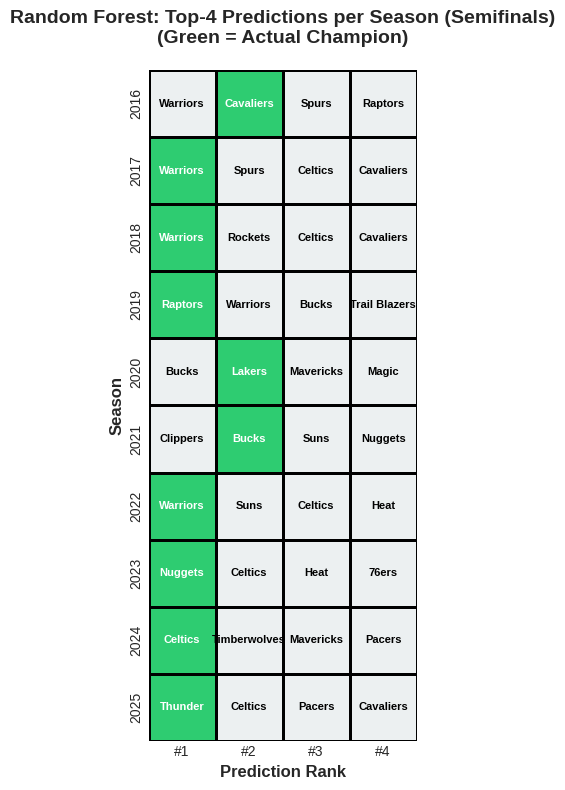

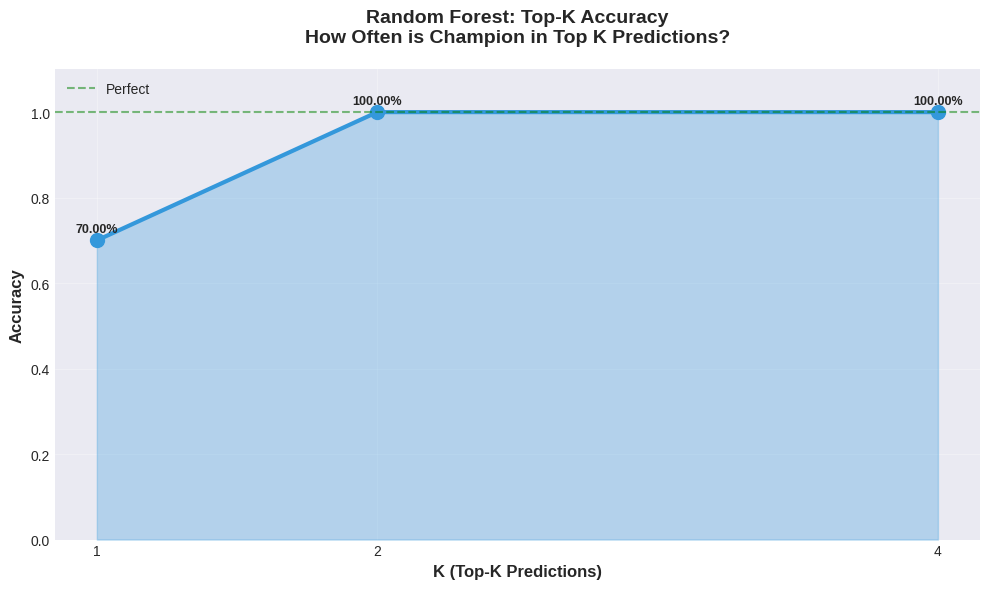

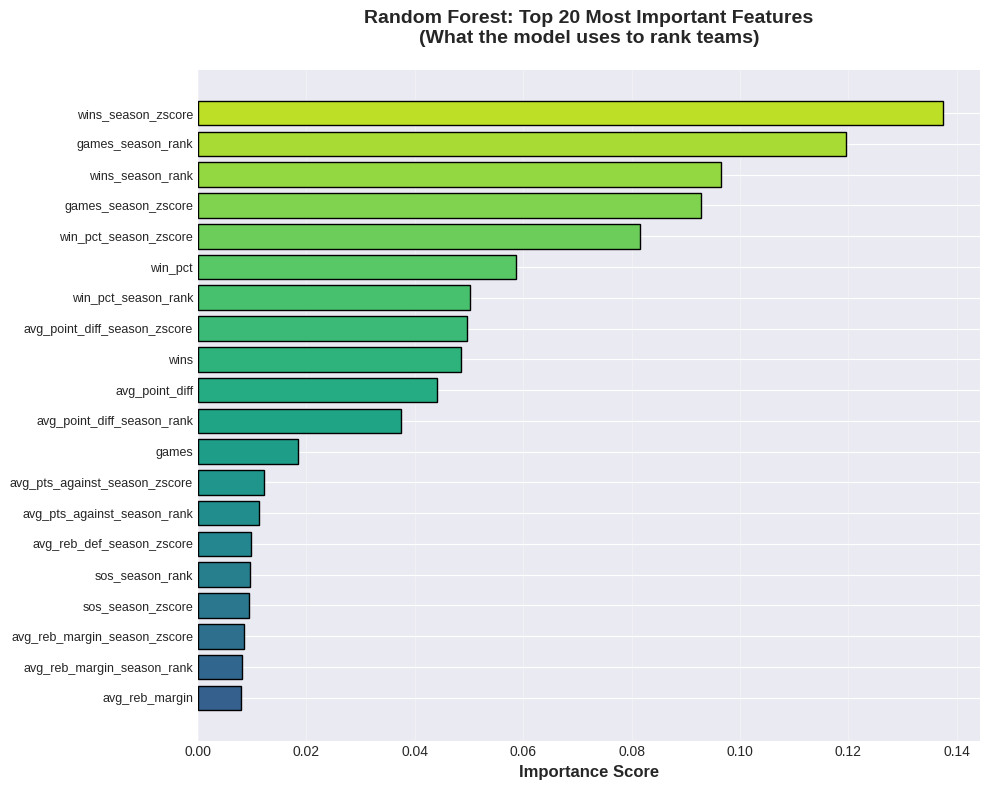

In [26]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

#1. Cool table showing the predicted rankings vs actual champion for the past 10 years
fig, ax = plt.subplots(figsize=(14, 8))

# for each season, get top 4 predictions
top4_per_season = []
for season in sorted(id_test['season'].unique()):
    season_data = id_test[id_test['season'] == season].copy()
    season_data = season_data.sort_values('ranking_score', ascending=False).head(4)

    actual_champ = id_test[(id_test['season'] == season) & (id_test['champion'] == 1)]['team'].values[0]

    for rank, (idx, row) in enumerate(season_data.iterrows(), 1):
        top4_per_season.append({
            'season': season,
            'rank': rank,
            'team': row['team'],
            'is_champion': row['team'] == actual_champ
        })

df_viz = pd.DataFrame(top4_per_season)

# pivot for heatmap
pivot = df_viz.pivot_table(index='season', columns='rank', values='is_champion', aggfunc='max')
pivot_teams = df_viz.pivot_table(index='season', columns='rank', values='team', aggfunc='first')

# create custom colormap
data_for_plot = pivot.fillna(False).astype(bool)

# plot heatmap
sns.heatmap(data_for_plot, cmap=['#ecf0f1', '#2ecc71'], cbar=False,
            linewidths=2, linecolor='black', square=True, ax=ax, annot=False)

# add team names as text annotations
for i, season in enumerate(pivot_teams.index):
    for j, rank in enumerate(pivot_teams.columns):
        team_name = pivot_teams.loc[season, rank]
        is_champ = data_for_plot.iloc[i, j]

        # abbreviate long team names
        if len(team_name) > 20:
            team_name = team_name[:17] + '...'

        color = 'white' if is_champ else 'black'
        ax.text(j + 0.5, i + 0.5, team_name,
                ha='center', va='center', fontsize=8, fontweight='bold', color=color)

ax.set_xlabel('Prediction Rank', fontsize=12, fontweight='bold')
ax.set_ylabel('Season', fontsize=12, fontweight='bold')
ax.set_title('Random Forest: Top-4 Predictions per Season (Semifinals)\n(Green = Actual Champion)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticklabels(['#1', '#2', '#3', '#4'], fontsize=10)

plt.tight_layout()
plt.show()

#2. Top-k accuracy graph
fig, ax = plt.subplots(figsize=(10, 6))

k_values = [1, 2, 4]
accuracies = [(true_champ_ranks <= k).mean() for k in k_values]

ax.plot(k_values, accuracies, marker='o', linewidth=3, markersize=10, color='#3498db')
ax.fill_between(k_values, accuracies, alpha=0.3, color='#3498db')

# add value labels on points
for k, acc in zip(k_values, accuracies):
    ax.text(k, acc + 0.02, f'{acc:.2%}', ha='center', fontsize=9, fontweight='bold')

ax.set_xlabel('K (Top-K Predictions)', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Random Forest: Top-K Accuracy\nHow Often is Champion in Top K Predictions?',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(k_values)
ax.set_ylim([0, 1.1])
ax.grid(alpha=0.3)
ax.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Perfect')
ax.legend()

plt.tight_layout()
plt.show()

#3. Feature importance graph
fig, ax = plt.subplots(figsize=(10, 8))

# Get the calibrated RF classifier from the pipeline
base_calibrated_clf = rf.named_steps['clf']
# Get the base estimator from CalibratedClassifierCV
base_rf = base_calibrated_clf.calibrated_classifiers_[0].estimator

feature_importance = base_rf.feature_importances_
importance_df = pd.DataFrame({
    'feature': num_cols_extended,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

# take top 20
top_features = importance_df.tail(20)

# create horizontal bar chart
bars = ax.barh(range(len(top_features)), top_features['importance'],
               color=plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features))),
               edgecolor='black', linewidth=1)

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'], fontsize=9)
ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_title('Random Forest: Top 20 Most Important Features\n(What the model uses to rank teams)',
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Predictions Using Random Forest Model

In [27]:
ds = load_dataset("dlpacoos/CS506_NBA", data_files="2026_stats_december.csv")
current_season = ds["train"].to_pandas()
print("="*80)
print("2025-2026 SEASON PREDICTION")
print("="*80)
print(f"\nLoaded {len(current_season)} teams for prediction")

# Create season-relative features for current season (same as training)
print("\nCreating season-relative features for current season...")

for col in num_cols:
    if col in current_season.columns:
        # Rank within current season (percentile)
        current_season[f'{col}_season_rank'] = current_season[col].rank(pct=True)

        # Z-score within current season
        col_mean = current_season[col].mean()
        col_std = current_season[col].std()
        if col_std > 0:
            current_season[f'{col}_season_zscore'] = (current_season[col] - col_mean) / col_std
        else:
            current_season[f'{col}_season_zscore'] = 0
    else:
        # If column is missing, add with default values
        print(f"Warning: {col} not found in current season data, using 0")
        current_season[col] = 0
        current_season[f'{col}_season_rank'] = 0.5
        current_season[f'{col}_season_zscore'] = 0

# Prepare features (use same extended features as training)
X_current = current_season[num_cols_extended].copy()
X_current = X_current.replace([np.inf, -np.inf], np.nan)

# Make predictions using the trained ranker
print("\nGenerating championship predictions...")
predictions = rf.predict_proba(X_current)[:, 1]

# ============================================
# Build results table for current season
# ============================================
results_2026 = pd.DataFrame({
    "team": current_season["team"],
    "ranking_score": predictions,          # P(team wins the title)
    "win_pct": current_season["win_pct"],  # current win %
    "wins": current_season["wins"],
    "games": current_season["games"],
    "avg_point_diff": current_season["avg_point_diff"],
})

# Sort by predicted title probability (highest first)
results_2026 = (
    results_2026
    .sort_values("ranking_score", ascending=False)
    .reset_index(drop=True)
)

# Add rank (1 = most likely champion)
results_2026["rank"] = np.arange(1, len(results_2026) + 1)

# ============================================
# Print predicted champion + top contenders
# ============================================
print("\n" + "="*80)
print("PREDICTED 2025–2026 NBA CHAMPIONSHIP RACE")
print("="*80)

# Predicted champion (rank 1)
champ = results_2026.iloc[0]
print(f"\nModel-predicted champion: #{champ['rank']} {champ['team']}")
print(f"  Championship probability score: {champ['ranking_score']:.4f}")
print(f"  Current record: {int(champ['wins'])}-{int(champ['games'] - champ['wins'])} "
      f"({champ['win_pct']:.3f} win%)")
print(f"  Avg point differential: {champ['avg_point_diff']:+.1f}")

# Top-4 contenders
top_k = 4
print(f"\nTop {top_k} title contenders:")
for _, row in results_2026.head(top_k).iterrows():
    print(
        f"  #{int(row['rank'])} {row['team']:>15}  "
        f"score={row['ranking_score']:.4f}  "
        f"record={int(row['wins'])}-{int(row['games'] - row['wins'])}  "
        f"pdiff={row['avg_point_diff']:+.1f}"
    )

# ============================================
# Optional: show full table or first N rows
# ============================================
print("\nFULL MODEL RANKINGS:")
print(
    results_2026[["rank", "team", "ranking_score", "win_pct", "wins", "avg_point_diff"]]
    .head(30)
    .to_string(index=False)
)

2025-2026 SEASON PREDICTION

Loaded 30 teams for prediction

Creating season-relative features for current season...

Generating championship predictions...

PREDICTED 2025–2026 NBA CHAMPIONSHIP RACE

Model-predicted champion: #1 Thunder
  Championship probability score: 0.0607
  Current record: 23-1 (0.958 win%)
  Avg point differential: +16.2

Top 4 title contenders:
  #1         Thunder  score=0.0607  record=23-1  pdiff=+16.2
  #2         Pistons  score=0.0144  record=19-5  pdiff=+5.5
  #3         Raptors  score=0.0130  record=15-11  pdiff=+1.9
  #4         Rockets  score=0.0111  record=15-6  pdiff=+10.6

FULL MODEL RANKINGS:
 rank          team  ranking_score  win_pct  wins  avg_point_diff
    1       Thunder       0.060743    0.958    23            16.2
    2       Pistons       0.014446    0.792    19             5.5
    3       Raptors       0.013042    0.577    15             1.9
    4       Rockets       0.011067    0.714    15            10.6
    5        Knicks       0.01080